Installations

In [219]:
%pip install matplotlib pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Imports

In [220]:
import subprocess
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

Preparing folder

In [221]:
examples_folder_path = '../../gen/examples/ex1/'
results_folder_path = "./results/"
main_path = "../../gen/main"
subprocess.run(f"mkdir {results_folder_path}", shell=True, stderr=subprocess.DEVNULL)
subprocess.run(f"rm {results_folder_path}*", shell=True)

CompletedProcess(args='rm ./results/*', returncode=0)

Gathering data

In [222]:
programs_rand_seed = 0
programs_loops_factor = 10

def get_program_compilation_time(it,opt):
    time_result : subprocess.CompletedProcess = subprocess.run(f"time clang -o output.o {opt} {results_folder_path}output_{it}.c",
                                                               check=True, shell=True, capture_output=True, text=True)
    elapsed_time_str = time_result.stderr.split(' ')[2]
    time_str = elapsed_time_str.replace('elapsed', '')
    time_str_list = time_str.split(':')
    secs = float(time_str_list[-1])
    mins = 0
    if len(time_str_list) >= 2:
        mins = int(time_str_list[-2])
    hours = 0
    if len(time_str_list) >= 3:
        hours = int(time_str_list[0])
    return hours*3600 + mins*60 + secs

def get_program_running_time():
    time_result : subprocess.CompletedProcess = subprocess.run(f"time ./output.o {programs_rand_seed} {programs_loops_factor}",
                                                               check=True, shell=True, capture_output=True, text=True)
    elapsed_time_str = time_result.stderr.split(' ')[2]
    time_str = elapsed_time_str.replace('elapsed', '')
    time_str_list = time_str.split(':')
    secs = float(time_str_list[-1])
    mins = 0
    if len(time_str_list) >= 2:
        mins = int(time_str_list[-2])
    hours = 0
    if len(time_str_list) >= 3:
        hours = int(time_str_list[0])
    return hours*3600 + mins*60 + secs

def get_program_size() -> int:
    size_result : subprocess.CompletedProcess = subprocess.run(f"size output.o", shell=True, capture_output=True, text=True)
    size_str = size_result.stdout.split('\n')[1].split('\t')
    return int(size_str[0])

def get_program_cpu_cycles() -> int:
    subprocess.run(f"perf stat -o temp.txt -e cycles ./output.o {programs_rand_seed} {programs_loops_factor}", shell=True, check=True)
    with open('temp.txt', 'r') as f:
        lines = f.readlines()
        lines = [line for line in lines if line.strip() != '']
        words = lines[2].strip().split(' ')
        cycles = int(words[0].replace('.', ''))
    return cycles

In [223]:
iterations_array = [10]
opts_array = ['-O0', '-O1', '-O2', '-O3']
iterations = []
opts = []
sizes = []
cpu_cycles = []
running_times = []
compilation_times = []
for it in iterations_array:
    subprocess.run(f"{main_path} {it} {examples_folder_path}production_rule.txt {examples_folder_path}seed_string.txt {results_folder_path}output_{it}.c scalar", check=True, shell=True)
    for opt in reversed(opts_array):
        iterations.append(it)
        opts.append(opt)
        compilation_times.append(get_program_compilation_time(it,opt))
        running_times.append(get_program_running_time())
        sizes.append(get_program_size())
        cpu_cycles.append(get_program_cpu_cycles())
subprocess.run(f"rm output.o temp.txt", shell=True)

Done!
Done!
Done!
Done!
Done!
Done!
Done!


rm: cannot remove 'temp.txt': No such file or directory


CompletedProcess(args='rm output.o temp.txt', returncode=1)

Building tables

In [224]:
df = pd.DataFrame({'Iterations': iterations, 'Optimizations': opts, 'Size (bytes)': sizes, 'Compilation Time (s)': compilation_times})
df.sort_values(by=['Iterations'], inplace=True)

subprocess.run(f"mkdir results", shell=True, stderr=subprocess.DEVNULL)
df.to_csv('results/table.csv', index=False)


with pd.ExcelWriter('results/tables.xlsx') as writer:
    df.to_excel(writer, sheet_name='Main Table', index=False)

Building graphs

In [225]:
file_name = 'results/graphs.pdf'
subprocess.run(f"rm {file_name}", shell=True, stderr=subprocess.DEVNULL)
pdf_file = PdfPages(file_name)

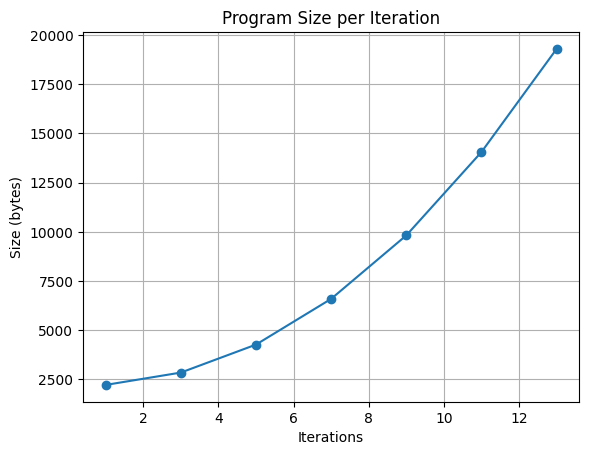

In [226]:
average_size_per_iteration = df.groupby('Iterations')['Size (bytes)'].mean()

plt.figure()
plt.plot(average_size_per_iteration.index, average_size_per_iteration.values, marker='o')
plt.title('Average Program Size per Iteration')
plt.xlabel('Iterations')
plt.ylabel('Average Size (bytes)')
plt.grid(True)
pdf_file.savefig()
plt.show()
plt.close()

In [231]:
pdf_file.close()